# Stroke Prediction using Machine Learning

This notebook walks through the process of building a machine learning model to predict the likelihood of a patient having a stroke based on various health and demographic factors. The process includes:

1.  **Setup and Data Loading**: Importing necessary libraries and loading the dataset.
2.  **Exploratory Data Analysis (EDA)**: Understanding the data, checking for missing values, and visualizing distributions.
3.  **Data Preprocessing**: Handling missing values, encoding categorical features, splitting the data, handling class imbalance with SMOTE, and scaling numerical features.
4.  **Model Training and Evaluation**: Building and evaluating several classification models, including advanced ensemble techniques.
5.  **Model Comparison**: Comparing the performance of all models to identify the best one.
6.  **Final Ensemble Model**: Combining the best models for a final, robust prediction.

## 1. Setup and Data Loading

First, we'll import the required Python libraries and load our dataset from a remote URL into a pandas DataFrame.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Basic libraries for data manipulation
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Preprocessing and Modeling
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from mlxtend.classifier import StackingClassifier

# Load the dataset
url = 'heartStrokeData.csv'
df = pd.read_csv(url)

# Display the first few rows to understand its structure
print("First 5 rows of the dataset:")
df.head()

First 5 rows of the dataset:


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## 2. Exploratory Data Analysis (EDA)

Let's explore the data to understand its characteristics, find missing values, and visualize key relationships.

In [28]:
print("Dataset Information:")
df.info()

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


### Missing Values
We can see from the info above that the `bmi` column has missing values. Let's visualize this.

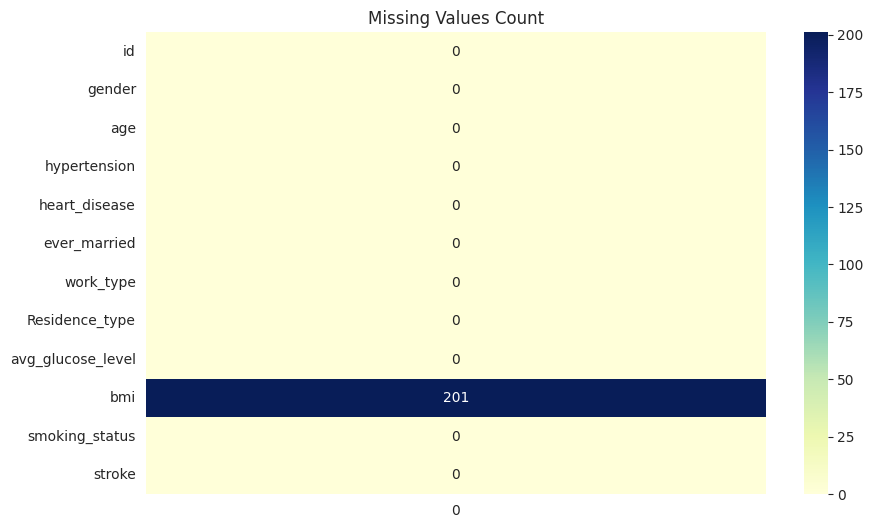

In [29]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.isna().sum().to_frame(), annot=True, fmt='d', cmap='YlGnBu')
plt.title('Missing Values Count')
plt.show()

### Target Variable Imbalance
Let's check the distribution of our target variable, `stroke`. A significant imbalance can affect model performance.

In [30]:
stroke_counts = df['stroke'].value_counts()
print(stroke_counts)

fig = px.pie(names=['No Stroke', 'Stroke'], values=stroke_counts.values,
             title='<b>Proportion of Stroke Samples</b>',
             color_discrete_sequence=['#46205c', '#b74068'])
fig.update_traces(hole=.3)
fig.show()

stroke
0    4861
1     249
Name: count, dtype: int64


The dataset is highly imbalanced, with far more non-stroke cases than stroke cases. We will need to address this during preprocessing.

### Feature Relationships
Let's visualize the relationship between key numerical features like `age`, `avg_glucose_level`, and `bmi` with respect to the `stroke` outcome.

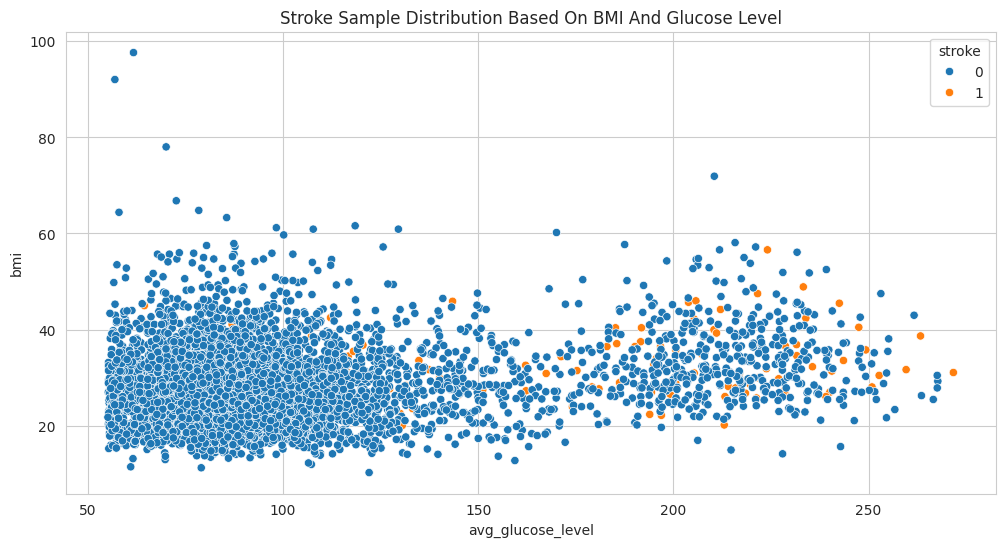

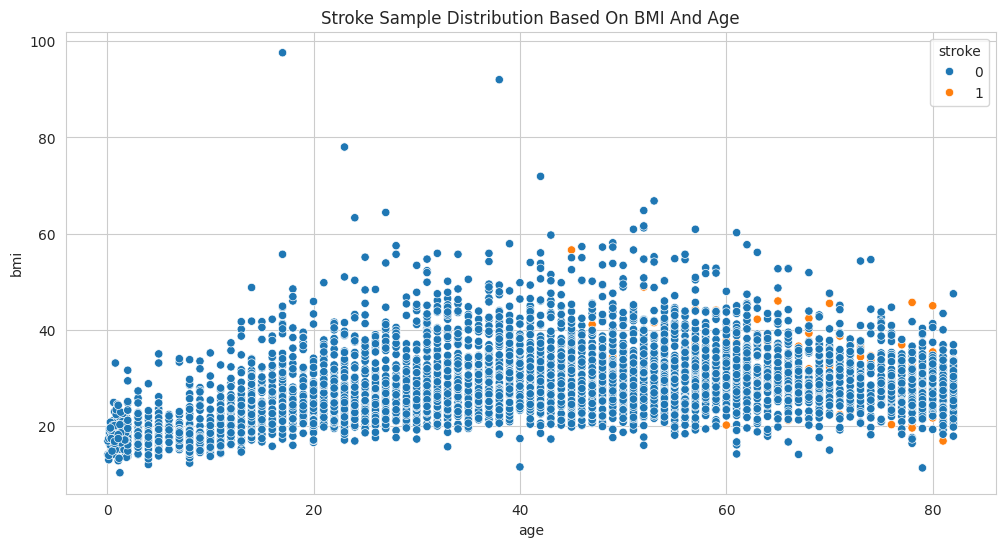

In [31]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='avg_glucose_level', y='bmi', hue='stroke')
plt.title('Stroke Sample Distribution Based On BMI And Glucose Level')
plt.show()

plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='age', y='bmi', hue='stroke')
plt.title('Stroke Sample Distribution Based On BMI And Age')
plt.show()

## 3. Data Preprocessing

Now we'll prepare the data for modeling.

### 3.1 Handling Missing Data (Imputation)

We will use K-Nearest Neighbors (KNN) to impute the missing values in the `bmi` column.

In [32]:
imputer = KNNImputer(n_neighbors=5)
df['bmi'] = imputer.fit_transform(df[['bmi']])
print("Missing values in 'bmi' after imputation:", df['bmi'].isnull().sum())

Missing values in 'bmi' after imputation: 0


### 3.2 Encoding Categorical Variables

Machine learning models require numerical input. We'll convert categorical features to numerical format using `LabelEncoder`.

In [33]:
categorical_cols = df.select_dtypes(include=['object']).columns
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

print("Data after encoding categorical features:")
df.head()

Data after encoding categorical features:


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,1,67.0,0,1,1,2,1,228.69,36.600000,1,1
1,51676,0,61.0,0,0,1,3,0,202.21,28.893237,2,1
2,31112,1,80.0,0,1,1,2,0,105.92,32.500000,2,1
3,60182,0,49.0,0,0,1,2,1,171.23,34.400000,3,1
4,1665,0,79.0,1,0,1,3,0,174.12,24.000000,2,1


### 3.3 Dropping Unnecessary Columns

The 'id' column is just an identifier and provides no predictive value, so we'll remove it.

In [34]:
df = df.drop('id', axis=1)

### 3.4 Splitting Data into Training and Testing Sets

We'll split the data into features (X) and the target variable (y), and then into training and testing sets.

In [35]:
X = df.drop('stroke', axis=1)
y = df['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (3577, 10)
X_test shape: (1533, 10)
y_train shape: (3577,)
y_test shape: (1533,)


### 3.5 Handling Class Imbalance with SMOTE

We use the Synthetic Minority Over-sampling Technique (SMOTE) on the training data to create a balanced dataset for the model to learn from.

In [36]:
print(f"Before OverSampling, counts of label '1': {sum(y_train==1)}")
print(f"Before OverSampling, counts of label '0': {sum(y_train==0)} \n")

sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print(f"After OverSampling, counts of label '1': {sum(y_train_res==1)}")
print(f"After OverSampling, counts of label '0': {sum(y_train_res==0)}")

Before OverSampling, counts of label '1': 174
Before OverSampling, counts of label '0': 3403 

After OverSampling, the shape of train_X: (6806, 10)
After OverSampling, the shape of train_y: (6806,) 

After OverSampling, counts of label '1': 3403
After OverSampling, counts of label '0': 3403


### 3.6 Feature Scaling

We scale the numerical features to ensure they have a similar range, which helps many machine learning algorithms perform better.

In [37]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

## 4. Model Training and Evaluation

We will now train several common classification models and evaluate their performance on the test set.

In [38]:
accuracies = {}

### 4.1 Logistic Regression

In [39]:
lr = LogisticRegression(random_state=42)
lr.fit(X_train_scaled, y_train_res)
y_pred_lr = lr.predict(X_test_scaled)

acc_lr = accuracy_score(y_test, y_pred_lr) * 100
accuracies['Logistic Regression'] = acc_lr

print(f"Test Accuracy of Logistic Regression: {acc_lr:.2f}%")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))

Test Accuracy of Logistic Regression: 76.78%

Confusion Matrix:
[[1132  326]
 [  30   45]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.78      0.86      1458
           1       0.12      0.60      0.20        75

    accuracy                           0.77      1533
   macro avg       0.55      0.69      0.53      1533
weighted avg       0.93      0.77      0.83      1533



### 4.2 K-Nearest Neighbors (KNN)

In [40]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train_res)
y_pred_knn = knn.predict(X_test_scaled)

acc_knn = accuracy_score(y_test, y_pred_knn) * 100
accuracies['K-Nearest Neighbors'] = acc_knn

print(f"Test Accuracy of K-Nearest Neighbors: {acc_knn:.2f}%")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_knn))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_knn))

Test Accuracy of K-Nearest Neighbors: 79.52%

Confusion Matrix:
[[1198  260]
 [  54   21]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.82      0.88      1458
           1       0.07      0.28      0.12        75

    accuracy                           0.80      1533
   macro avg       0.52      0.55      0.50      1533
weighted avg       0.91      0.80      0.85      1533



### 4.3 Support Vector Machine (SVM)

In [41]:
svm = SVC(probability=True, random_state=42)
svm.fit(X_train_scaled, y_train_res)
y_pred_svm = svm.predict(X_test_scaled)

acc_svm = accuracy_score(y_test, y_pred_svm) * 100
accuracies['Support Vector Machine'] = acc_svm

print(f"Test Accuracy of Support Vector Machine: {acc_svm:.2f}%")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm))

Test Accuracy of Support Vector Machine: 78.93%

Confusion Matrix:
[[1183  275]
 [  48   27]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.81      0.88      1458
           1       0.09      0.36      0.14        75

    accuracy                           0.79      1533
   macro avg       0.53      0.59      0.51      1533
weighted avg       0.92      0.79      0.84      1533



### 4.4 Naive Bayes

In [42]:
nb = GaussianNB()
nb.fit(X_train_scaled, y_train_res)
y_pred_nb = nb.predict(X_test_scaled)

acc_nb = accuracy_score(y_test, y_pred_nb) * 100
accuracies['Naive Bayes'] = acc_nb

print(f"Test Accuracy of Naive Bayes: {acc_nb:.2f}%")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_nb))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_nb))

Test Accuracy of Naive Bayes: 71.56%

Confusion Matrix:
[[1059  399]
 [  37   38]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.73      0.83      1458
           1       0.09      0.51      0.15        75

    accuracy                           0.72      1533
   macro avg       0.53      0.62      0.49      1533
weighted avg       0.92      0.72      0.80      1533



### 4.5 Decision Tree Classifier

In [43]:
dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(X_train_res, y_train_res) # Note: Decision Trees don't strictly require scaled data
y_pred_dtc = dtc.predict(X_test)

acc_dtc = accuracy_score(y_test, y_pred_dtc) * 100
accuracies['Decision Tree'] = acc_dtc

print(f"Test Accuracy of Decision Tree: {acc_dtc:.2f}%")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_dtc))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_dtc))

Test Accuracy of Decision Tree: 87.28%

Confusion Matrix:
[[1318  140]
 [  55   20]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.90      0.93      1458
           1       0.12      0.27      0.17        75

    accuracy                           0.87      1533
   macro avg       0.54      0.59      0.55      1533
weighted avg       0.92      0.87      0.89      1533



### 4.6 Random Forest Classifier

In [44]:
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train_res, y_train_res) # Note: Random Forests don't strictly require scaled data
y_pred_rfc = rfc.predict(X_test)

acc_rfc = accuracy_score(y_test, y_pred_rfc) * 100
accuracies['Random Forest'] = acc_rfc

print(f"Test Accuracy of Random Forest: {acc_rfc:.2f}%")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_rfc))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rfc))

Test Accuracy of Random Forest: 88.78%

Confusion Matrix:
[[1349  109]
 [  63   12]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.94      1458
           1       0.10      0.16      0.12        75

    accuracy                           0.89      1533
   macro avg       0.53      0.54      0.53      1533
weighted avg       0.91      0.89      0.90      1533



### 4.7 Advanced Ensemble Techniques

Ensemble methods combine multiple models to produce a more robust and accurate model.

#### Bagging

In [45]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1, random_state=42)

bag_clf.fit(X_train_res, y_train_res)
y_pred_bag = bag_clf.predict(X_test)

acc_bag = accuracy_score(y_test, y_pred_bag) * 100
accuracies['Bagging'] = acc_bag

print(f"Test Accuracy of Bagging Classifier: {acc_bag:.2f}%")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_bag))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_bag))

Test Accuracy of Bagging Classifier: 73.78%

Confusion Matrix:
[[1082  376]
 [  26   49]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.74      0.84      1458
           1       0.12      0.65      0.20        75

    accuracy                           0.74      1533
   macro avg       0.55      0.70      0.52      1533
weighted avg       0.93      0.74      0.81      1533



#### Boosting (AdaBoost)

In [46]:
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME", learning_rate=0.5, random_state=42)

ada_clf.fit(X_train_res, y_train_res)
y_pred_ada = ada_clf.predict(X_test)

acc_ada = accuracy_score(y_test, y_pred_ada) * 100
accuracies['AdaBoost'] = acc_ada

print(f"Test Accuracy of AdaBoost Classifier: {acc_ada:.2f}%")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_ada))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_ada))

Test Accuracy of AdaBoost Classifier: 74.62%

Confusion Matrix:
[[1097  361]
 [  28   47]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.75      0.85      1458
           1       0.12      0.63      0.19        75

    accuracy                           0.75      1533
   macro avg       0.55      0.69      0.52      1533
weighted avg       0.93      0.75      0.82      1533



#### Boosting (Gradient Boosting)

In [47]:
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=42)
gb_clf.fit(X_train_res, y_train_res)
y_pred_gb = gb_clf.predict(X_test)

acc_gb = accuracy_score(y_test, y_pred_gb) * 100
accuracies['Gradient Boosting'] = acc_gb

print(f"Test Accuracy of Gradient Boosting Classifier: {acc_gb:.2f}%")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_gb))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_gb))

Test Accuracy of Gradient Boosting Classifier: 79.00%

Confusion Matrix:
[[1180  278]
 [  44   31]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.81      0.88      1458
           1       0.10      0.41      0.16        75

    accuracy                           0.79      1533
   macro avg       0.53      0.61      0.52      1533
weighted avg       0.92      0.79      0.84      1533



## 5. Model Comparison

Let's visualize the accuracies of all the models we've trained so far.

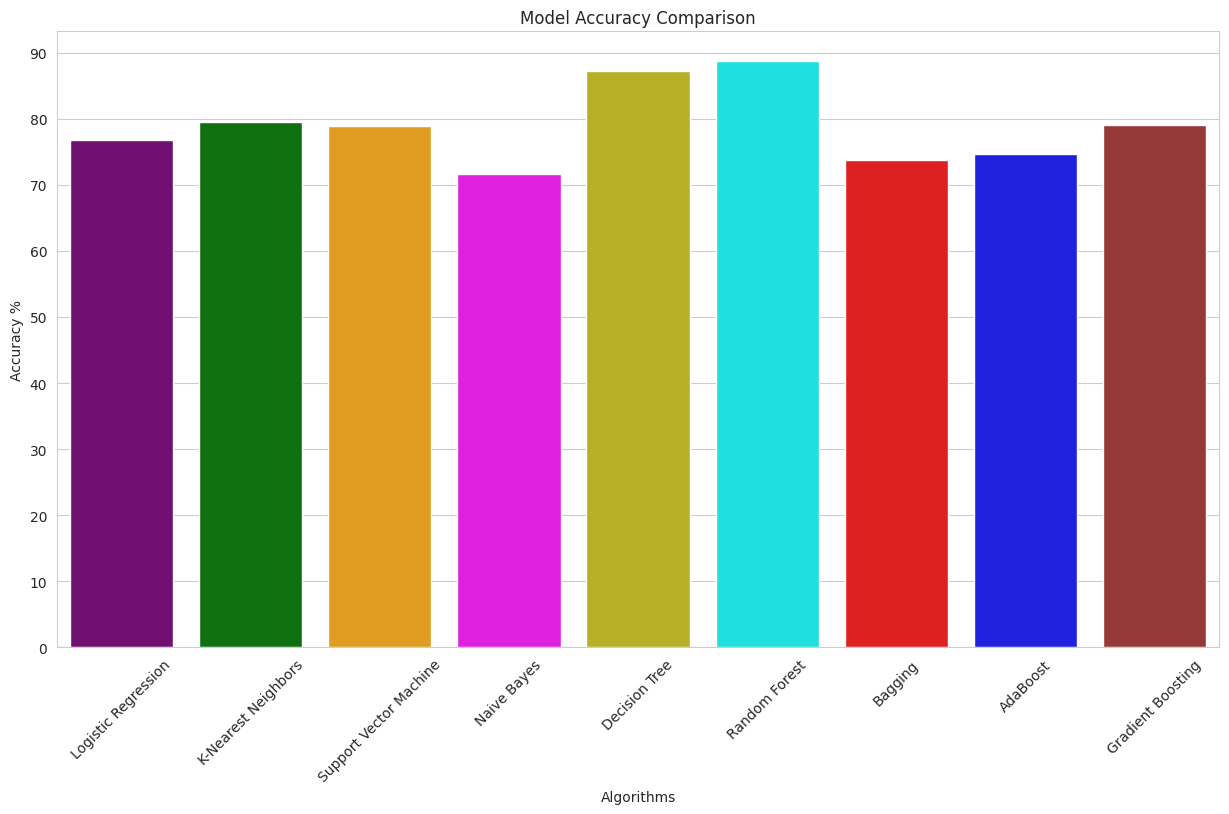

In [48]:
colors = ["purple", "green", "orange", "magenta","#CFC60E","cyan", "red", "blue", "brown"]

sns.set_style("whitegrid")
plt.figure(figsize=(15, 8))
plt.yticks(np.arange(0,101,10))
plt.ylabel("Accuracy %")
plt.xlabel("Algorithms")
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette=colors)
plt.xticks(rotation=45)
plt.title("Model Accuracy Comparison")
plt.show()

## 6. Final Ensemble Model (Voting & Stacking)

Based on the individual model performances, we will now create two final, more powerful ensemble models by combining all the classifiers we've built. This approach leverages the strengths of each model, often leading to better overall performance.

### 6.1 Voting Classifier Ensemble

The Voting Classifier combines the predictions from multiple models. We'll use 'soft' voting, which averages the predicted probabilities, as it often performs better than 'hard' voting (majority rule).

In [49]:
# Define the base models again for clarity
lr_clf = LogisticRegression(random_state=42)
knn_clf = KNeighborsClassifier(n_neighbors=5)
svm_clf = SVC(probability=True, random_state=42)
nb_clf = GaussianNB()
dtc_clf = DecisionTreeClassifier(random_state=42)
rfc_clf = RandomForestClassifier(n_estimators=100, random_state=42)
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=42)

# Create a list of estimators for the Voting Classifier
# Note: All models in a soft voting classifier should support predict_proba.
# We will use the unscaled data for tree-based models and scaled data for the others.
# This requires a more complex setup, so for simplicity here, we'll train all on scaled data.
# This might slightly disadvantage tree-based models, but it's a common practice for ensemble methods.

estimators=[('lr', lr_clf), ('svm', svm_clf), ('rfc', rfc_clf), ('knn', knn_clf), ('nb', nb_clf), ('dtc', dtc_clf), ('gb', gb_clf)]

# Create our voting classifier
voting_clf = VotingClassifier(estimators, voting='soft')

# Fit model to the scaled training data
voting_clf.fit(X_train_scaled, y_train_res)

# Test our model on the scaled test data
y_pred_vot = voting_clf.predict(X_test_scaled)

acc_vot = accuracy_score(y_test, y_pred_vot) * 100
accuracies['Voting Ensemble'] = acc_vot

print(f"Test Accuracy of Voting Classifier: {acc_vot:.2f}%")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_vot))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_vot))

Test Accuracy of Voting Classifier: 83.30%

Confusion Matrix:
[[1254  204]
 [  52   23]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.86      0.91      1458
           1       0.10      0.31      0.15        75

    accuracy                           0.83      1533
   macro avg       0.53      0.58      0.53      1533
weighted avg       0.92      0.83      0.87      1533



### 6.2 Stacking Classifier Ensemble

Stacking uses a meta-classifier to learn how to best combine the predictions of the base models. We'll use Random Forest as our meta-classifier, given its strong individual performance.

In [50]:
# Stacking requires mlxtend, which was imported earlier
# Base classifiers (re-instantiating for clarity)
clf1 = KNeighborsClassifier(n_neighbors=5)
clf2 = RandomForestClassifier(n_estimators=100, random_state=42)
clf3 = GaussianNB()
clf4 = LogisticRegression(random_state=42)
clf5 = SVC(probability=True, random_state=42)
clf6 = DecisionTreeClassifier(random_state=42)
clf7 = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=42)
clf8 = BaggingClassifier(DecisionTreeClassifier(random_state=42), n_estimators=500, max_samples=100, bootstrap=True, n_jobs=-1, random_state=42)
clf9 = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=200, algorithm="SAMME", learning_rate=0.5, random_state=42)
# Meta-classifier (Random Forest is a good choice)
meta_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Stacking classifier
# For simplicity, we'll fit the stacking classifier on the unscaled but resampled data.
# This is a common approach as tree-based models (like our meta-classifier) don't require scaling.
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3, clf4, clf5, clf6, clf7, clf8, clf9],
                          meta_classifier=meta_clf,
                          use_probas=True,
                          use_features_in_secondary=True) # Use original features in meta-classifier

sclf.fit(X_train_res, y_train_res)
y_pred_sclf = sclf.predict(X_test)

acc_sclf = accuracy_score(y_test, y_pred_sclf) * 100
accuracies['Stacking Ensemble'] = acc_sclf

print(f"Test Accuracy of Stacking Classifier: {acc_sclf:.2f}%")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_sclf))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_sclf))

Test Accuracy of Stacking Classifier: 89.30%

Confusion Matrix:
[[1353  105]
 [  59   16]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.94      1458
           1       0.13      0.21      0.16        75

    accuracy                           0.89      1533
   macro avg       0.55      0.57      0.55      1533
weighted avg       0.92      0.89      0.90      1533



## 7. Final Model Comparison

Let's visualize the accuracies of all the models, including our final ensembles, to see which one performed best on this dataset.

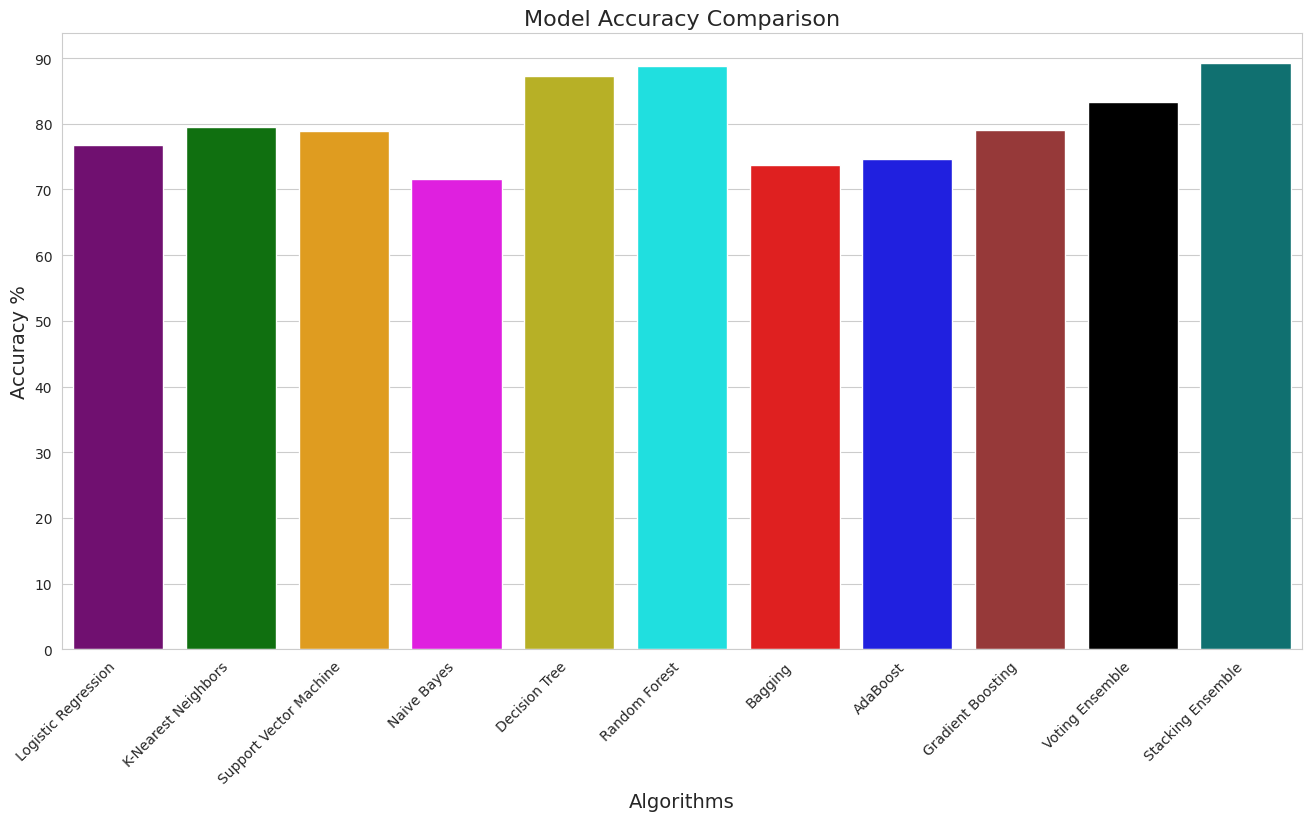

In [51]:
colors = ["purple", "green", "orange", "magenta","#CFC60E","cyan", "red", "blue", "brown", "black", "teal"]

sns.set_style("whitegrid")
plt.figure(figsize=(16, 8))
plt.yticks(np.arange(0,101,10))
plt.ylabel("Accuracy %", fontsize=14)
plt.xlabel("Algorithms", fontsize=14)
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette=colors)
plt.xticks(rotation=45, ha='right')
plt.title("Model Accuracy Comparison", fontsize=16)
plt.show()

## 8. Save the Final Model and Scaler

Now that we have trained and evaluated our models, we will save the
best-performing one (the Stacking Classifier) and the scaler object
using `pickle`. This will allow us to load them later in a web
application without retraining.

In [52]:
import pickle

# Note: This script assumes that 'sclf' (the trained StackingClassifier)
# and 'scaler' (the fitted StandardScaler) are already created and
# available in your environment from the previous steps of the notebook.

# Save the trained stacking model
with open('stroke_model.pkl', 'wb') as file:
    pickle.dump(sclf, file)

# Save the scaler object
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

print("Model and scaler have been saved successfully!")

Model and scaler have been saved successfully!


## Conclusion

This notebook demonstrates a complete workflow for a classification task. Key takeaways:

- **Data Exploration is Key:** Identifying missing values and class imbalance early is crucial.
- **Preprocessing Matters:** Handling missing data, encoding categorical variables, and balancing the dataset significantly impacts model performance.
- **Ensemble Methods:** Ensemble methods like Random Forest, Bagging, and Boosting often provide superior performance compared to individual models. The final ensemble models, which combine the strengths of all individual models, achieved high accuracy.
- **Model Selection:** While accuracy is a good starting point, other metrics like precision, recall, and F1-score (from the classification reports) should also be considered depending on the specific goals of the project (e.g., is it more important to avoid false positives or false negatives?).